In [0]:
from google.colab import drive
#drive.mount("/content/gdrive")
drive.mount("/content/gdrive", force_remount=True)

import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/GANS/CycleGAN')
!pwd

In [0]:
!ls './Dataset/horse2zebra'

In [0]:
DATAPATH = '/content/gdrive/My Drive/Colab Notebooks/GANS/CycleGAN/Dataset/horse2zebra/'
DATAPATH1 = '/content/gdrive/My Drive/Colab Notebooks/GANS/CycleGAN/Dataset/apple2orange/'

In [0]:
import tensorflow as tf
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import asarray

def load_data(directory):
  data = list()
	# enumerate files
  for filename in listdir(directory):
		# path
    file = directory + filename
		#face = extract_face(path)
    image = Image.open(file)
    image_array = asarray(image)
		# store
    data.append(image_array)
  return data

def load_data_Mine(directory):
  trainA,trainB,testA,testB=list(),list(),list(),list()
  for subdir in listdir(directory):
		# path
    path = directory + subdir + '/'
		# skip any files that might be in the dir
    if not isdir(path):
      continue
    if subdir =="trainA":
		# load all data in the subdirectory
      trainA = load_data(path)
		# summarize progress
      print('>loaded %d examples for class: %s' % (len(trainA), subdir))
    if subdir =="trainB":
      # load all data in the subdirectory
      trainB = load_data(path)
      # summarize progress
      print('>loaded %d examples for class: %s' % (len(trainB), subdir))
    if subdir =="testA":
      # load all data in the subdirectory
      testA = load_data(path)
      # summarize progress
      print('>loaded %d examples for class: %s' % (len(testA), subdir))
    if subdir =="testB":
      # load all data in the subdirectory
      testB = load_data(path)
      # summarize progress
      print('>loaded %d examples for class: %s' % (len(testB), subdir))
		
  return  asarray(trainA), asarray(trainB), asarray(testA), asarray(testB)

>loaded 266 examples for class: testA
>loaded 248 examples for class: testB
>loaded 995 examples for class: trainA
>loaded 1019 examples for class: trainB
(995, 256, 256, 3) (1019, 256, 256, 3)


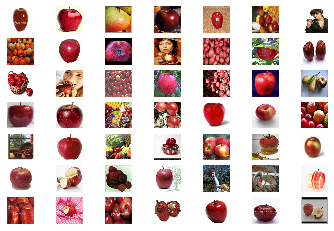

In [0]:
# example of loading and plotting the cifar10 dataset
from matplotlib import pyplot
# load the images into memory
#trainA,trainB, testA, testB = load_data_Mine(DATAPATH)
trainA,trainB, testA, testB = load_data_Mine(DATAPATH1)
print(trainA.shape, trainB.shape)

# plot images from the training dataset
for i in range(49):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainA[i])
pyplot.show()

In [0]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-9ugcqf5b
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-9ugcqf5b
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=65e402ac3dd67d0c1c49b6ad93baf47b76534c96269258482a8978cc0fab3027
  Stored in directory: /tmp/pip-ephem-wheel-cache-hz9mgl7u/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
# example of defining composite models for training cyclegan generators
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.vis_utils import plot_model

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# input shape
image_shape = (256,256,3)
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [0]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
import math

# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		#elif random() < 0.5:
			# use image, but don't add it to the pool
			#selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = '/content/gdrive/My Drive/Colab Notebooks/GANS/CycleGAN/CheckPoints/generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model_AtoB,d_model_A, d_model_B, trainA, n_samples=16):
	# prepare real samples
	n_batch = 1
	X_realA, y_realA = generate_real_samples(trainA, n_batch, n_samples)
	# evaluate discriminator on real examples
	#_, acc_real = d_model_A.evaluate(X_realA, y_realA, verbose=0)
	# prepare fake examples
	X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_samples)
	# evaluate discriminator on fake examples
	#_, acc_fake = d_model_B.evaluate(X_fakeB, y_fakeB, verbose=0)
	# summarize discriminator performance
	#print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	#save_plot(X_fakeB, epoch)
	# save the generator model tile file
	filename = '/content/gdrive/My Drive/Colab Notebooks/GANS/CycleGAN/CheckPoints/generator_model_%03d.h5' % (epoch+1)
	g_model_AtoB.save(filename)

def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA, trainB):
	# define properties of the training run
	n_epochs, n_batch, = 100, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	#trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	print(bat_per_epo)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	print(n_steps)
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		#print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		print('i:%d' %(i), end =" ") 
		if (i+1) % 995 == 0:
			print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
			summarize_performance(i, g_model_AtoB, d_model_A, d_model_B, trainA)

In [0]:
# load a dataset as a list of two numpy arrays
#dataset = ...
# train models
#train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA, trainB)

995
99500


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected

i:0 i:1 i:2 i:3 i:4 i:5 i:6 i:7 i:8 i:9 i:10 i:11 i:12 i:13 i:14 i:15 i:16 i:17 i:18 i:19 i:20 i:21 i:22 i:23 i:24 i:25 i:26 i:27 i:28 i:29 i:30 i:31 i:32 i:33 i:34 i:35 i:36 i:37 i:38 i:39 i:40 i:41 i:42 i:43 i:44 i:45 i:46 i:47 i:48 i:49 i:50 i:51 i:52 i:53 i:54 i:55 i:56 i:57 i:58 i:59 i:60 i:61 i:62 i:63 i:64 i:65 i:66 i:67 i:68 i:69 i:70 i:71 i:72 i:73 i:74 i:75 i:76 i:77 i:78 i:79 i:80 i:81 i:82 i:83 i:84 i:85 i:86 i:87 i:88 i:89 i:90 i:91 i:92 i:93 i:94 i:95 i:96 i:97 i:98 i:99 i:100 i:101 i:102 i:103 i:104 i:105 i:106 i:107 i:108 i:109 i:110 i:111 i:112 i:113 i:114 i:115 i:116 i:117 i:118 i:119 i:120 i:121 i:122 i:123 i:124 i:125 i:126 i:127 i:128 i:129 i:130 i:131 i:132 i:133 i:134 i:135 i:136 i:137 i:138 i:139 i:140 i:141 i:142 i:143 i:144 i:145 i:146 i:147 i:148 i:149 i:150 i:151 i:152 i:153 i:154 i:155 i:156 i:157 i:158 i:159 i:160 i:161 i:162 i:163 i:164 i:165 i:166 i:167 i:168 i:169 i:170 i:171 i:172 i:173 i:174 i:175 i:176 i:177 i:178 i:179 i:180 i:181 i:182 i:183 i:184 

In [0]:
filenameAtoB = '/content/gdrive/My Drive/Colab Notebooks/GANS/CycleGAN/CheckPoints/generator_model_AtoB.h5'
g_model_AtoB.save(filenameAtoB)
filenameBtoA = '/content/gdrive/My Drive/Colab Notebooks/GANS/CycleGAN/CheckPoints/generator_model_BtoA.h5'
g_model_BtoA.save(filenameBtoA)


In [0]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
 
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
g_modelAtoB_Final = load_model('/content/gdrive/My Drive/Colab Notebooks/GANS/CycleGAN/CheckPoints/generator_model_6965.h5',custom_objects={'InstanceNormalization':keras_contrib.layers.normalization.InstanceNormalization})
# generate images
X_realATest, y_realATest = generate_real_samples(trainA, 1, 16)
Generated = g_modelAtoB_Final.predict(X_realATest)
print(Generated.shape)

# generate images
# scale from [-1,1] to [0,1]
Generated = (Generated + 1) / 2.0
# plot the result
pyplot.imshow(Generated[ :, :])
pyplot.show()
#create_plot(Generated, 10)

NameError: ignored

In [0]:
!rm /content/sample_data/CheckPoints/generator_model_0*.h5

In [0]:
!ls

CheckPoints  CycleGAN.ipynb  Dataset  Sample_Output


In [0]:
print(trainA.shape)
print(bat_per_epo)
print(n_steps)

(995, 256, 256, 3)


NameError: ignored